## Friday, March 28, 2024

Does this still work?? ... Let's find out ... 

Stepped through most of the notebook. Very few last cells I did not run ... 

[OpenAI usage](https://platform.openai.com/usage) went from $0.68 to $1.07

## Monday, February 19, 2024

[The 5 Levels of Text Splitting for Retrieval](https://www.youtube.com/watch?v=8OJC21T2SL4)

## Thursday, February 15, 2024

https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb

This notebook uses both LangChain and LLamaIndex.

# 5 Levels Of Text Splitting

In this tutorial we are reviewing the 5 Levels Of Text Splitting. This is an unofficial list put together for fun and educational purposes.

Ever try to put a long piece of text into ChatGPT but it tells you it’s too long? Or you're trying to give your application better long term memory, but it’s still just not quite working.

One of the most effective strategies to improve performance of your language model applications is to split your large data into smaller pieces. This is call splitting or chunking (we'll use these terms interchangeably). In the world of multi-modal, splitting also applies to images.

We are going to cover a lot, but if you make it to the end, I guarantee you’ll have a solid grasp on chunking theory, strategies, and resources to learn more.

**Levels Of Text Splitting**
* **Level 1: [Character Splitting](#CharacterSplitting)** - Simple static character chunks of data
* **Level 2: [Recursive Character Text Splitting](#RecursiveCharacterSplitting)** - Recursive chunking based on a list of separators
* **Level 3: [Document Specific Splitting](#DocumentSpecific)** - Various chunking methods for different document types (PDF, Python, Markdown)
* **Level 4: [Semantic Splitting](#SemanticChunking)** - Embedding walk based chunking
* **Level 5: [Agentic Splitting](#AgenticChunking)** - Experimental method of splitting text with an agent-like system. Good for if you believe that token cost will trend to $0.00
* **\*Bonus Level:\*** **[Alternative Representation Chunking + Indexing](#BonusLevel)** - Derivative representations of your raw text that will aid in retrieval and indexing

**Notebook resources:**
* [Video Overview]() - Walkthrough of this code with commentary
* [ChunkViz.com](https://www.chunkviz.com/) - Visual representation of chunk splitting methods
* [RAGAS](https://github.com/explodinggradients/ragas) - Retrieval evaluation framework

This tutorial was created with ❤️ by [Greg Kamradt](https://twitter.com/GregKamradt). MIT license, attribution is always welcome.

This tutorial will use code from LangChain (`pip install langchain`) & Llama Index (`pip install llama-index`)

**Evaluations**

It's important to test your chunking strategies in retrieval evals. It doesn't matter how you chunk if the performance of your application isn't great.

Eval Frameworks:

* [LangChain Evals](https://python.langchain.com/docs/guides/evaluation/)
* [Llama Index Evals](https://docs.llamaindex.ai/en/stable/module_guides/evaluating/root.html)
* [RAGAS Evals](https://github.com/explodinggradients/ragas)

I'm not going to demo evals for each method because success is domain specific. The arbitrary eval that I pick may not be suitable for your data. If anyone is interested in collaborating on a rigorous evaluation of different chunking strategies, please reach out (contact@dataindependent.com).

If you only walk away from this tutorial with one thing have it be the **The Chunking Commandment**

**The Chunking Commandment:** Your goal is not to chunk for chunking sake, our goal is to get our data in a format where it can be retrieved for value later.

## Level 1: Character Splitting <a id="CharacterSplitting"></a>
Character splitting is the most basic form of splitting up your text. It is the process of simply dividing your text into N-character sized chunks regardless of their content or form.

This method isn't recommended for any applications - but it's a great starting point for us to understand the basics.

* **Pros:** Easy & Simple
* **Cons:** Very rigid and doesn't take into account the structure of your text

Concepts to know:
* **Chunk Size** - The number of characters you would like in your chunks. 50, 100, 100,000, etc.
* **Chunk Overlap** - The amount you would like your sequential chunks to overlap. This is to try to avoid cutting a single piece of context into multiple pieces. This will create duplicate data across chunks.

First let's get some sample text

In [1]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

Then let's split this text manually

In [2]:
# Create a list that will hold your chunks
chunks = []

chunk_size = 35 # Characters

# Run through the a range with the length of your text and iterate every chunk_size you want
for i in range(0, len(text), chunk_size):
    chunk = text[i:i + chunk_size]
    chunks.append(chunk)
chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

Congratulations! You just split your first text. We have long way to go but you're already making progress. Feel like a language model practitioner yet?

When working with text in the language model world, we don't deal with raw strings. It is more common to work with documents. Documents are objects that hold the text you're concerned with, but also additional metadata which makes filtering and manipulation easier later.

We could convert our list of strings into documents, but I'd rather start from scratch and create the docs.

Let's load up LangChains `CharacterSplitter` to do this for us

In [3]:
from langchain.text_splitter import CharacterTextSplitter

Then let's load up this text splitter. I need to specify `chunk overlap` and `separator` or else we'll get funk results. We'll get into those next

In [4]:
text_splitter = CharacterTextSplitter(chunk_size = 35, chunk_overlap=0, separator='', strip_whitespace=False)

Then we can actually split our text via `create_documents`. Note: `create_documents` expects a list of texts, so if you just have a string (like we do) you'll need to wrap it in `[]`

In [5]:
text_splitter.create_documents([text])

[Document(page_content='This is the text I would like to ch'),
 Document(page_content='unk up. It is the example text for '),
 Document(page_content='this exercise')]

Notice how this time we have the same chunks, but they are in documents. These will play nicely with the rest of the LangChain world. Also notice how the trailing whitespace on the end of the 2nd chunk is missing. This is because LangChain removes it, see [this line](https://github.com/langchain-ai/langchain/blob/f36ef0739dbb548cabdb4453e6819fc3d826414f/libs/langchain/langchain/text_splitter.py#L167) for where they do it. You can avoid this with `strip_whitespace=False`

**Chunk Overlap & Separators**

**Chunk overlap** will blend together our chunks so that the tail of Chunk #1 will be the same thing and the head of Chunk #2 and so on and so forth.

This time I'll load up my overlap with a value of 4, this means 4 characters of overlap

In [6]:
text_splitter = CharacterTextSplitter(chunk_size = 35, chunk_overlap=4, separator='')

In [7]:
text_splitter.create_documents([text])

[Document(page_content='This is the text I would like to ch'),
 Document(page_content='o chunk up. It is the example text'),
 Document(page_content='ext for this exercise')]

Notice how we have the same chunks, but now there is overlap between 1 & 2 and 2 & 3. The 'o ch' on the tail of Chunk #1 matches the 'o ch' of the head of Chunk #2.

I wanted a better way to visualize this, so I made [ChunkViz.com](www.chunkviz.com) to help show it. Here's what the same text looks like.

<div style="text-align: center;">
    <img src="static/ChunkVizCharacter34_4_w_overlap.png" alt="image" style="max-width: 800px;">
</div>

static/ChunkVizCharacterRecursive.png

Check out how we have three colors, with two overlaping sections.

**Separators** are character(s) sequences you would like to split on. Say you wanted to chunk your data at `ch`, you can specify it.

In [8]:
text_splitter = CharacterTextSplitter(chunk_size = 35, chunk_overlap=0, separator='ch')

In [9]:
text_splitter.create_documents([text])

[Document(page_content='This is the text I would like to'),
 Document(page_content='unk up. It is the example text for this exercise')]

#### Llama Index

[Llama Index](https://www.llamaindex.ai/) is a great choice for flexibility in the chunking and indexing process. They provide node relationships out of the box which can aid in retrieval later.

Let's take a look at their sentence splitter. It is similar to the character splitter, but using its default settings, it'll split on sentences instead.

In [10]:
from llama_index.text_splitter import SentenceSplitter
from llama_index import SimpleDirectoryReader

Load up your splitter

In [11]:
splitter = SentenceSplitter(
    chunk_size=200,
    chunk_overlap=15,
)

Load up your document

(You can find these Paul Graham Essays [here](https://github.com/gkamradt/langchain-tutorials/tree/c00a0e56b11f5c1d8aae53b3c7966169724e6dbd/data))

In [12]:
documents = SimpleDirectoryReader(
    input_files=["PaulGrahamEssayMedium/mit.txt"]
).load_data()

Create your nodes. Nodes are similar to documents but with more relationship data added to them.

In [13]:
nodes = splitter.get_nodes_from_documents(documents)

Then let's take a look at one

In [14]:
nodes[0]

TextNode(id_='ccacce39-40e3-49fa-af5c-22fbbd6db7f4', embedding=None, metadata={'file_path': 'PaulGrahamEssayMedium/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36044, 'creation_date': '2024-02-15', 'last_modified_date': '2024-02-15', 'last_accessed_date': '2024-03-28'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a10414ed-2425-454f-942f-cbb7df95cac2', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'PaulGrahamEssayMedium/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36044, 'creation_date': '2024-02-15', 'last_modified_date': '2024-02-15', 'last_accessed_date': '2024-03-28'}, hash='4d59b6f83fc34c589e09a20c0e085bce569abb5772095a9d6b39dc

As you can see there is a lot more relationship data held within Llama Index's nodes. We'll talk about those later, I don't want to get ahead of ourselves

Basic Character splitting is likely only useful for a few applications, maybe yours!

## Level 2: Recursive Character Text Splitting
<a id="RecursiveCharacterSplitting"></a>
Let's jump a level of complexity.

The problem with Level #1 is that we don't take into account the structure of our document at all. We simply split by a fix number of characters.

The Recursive Character Text Splitter helps with this. With it, we'll specify a series of separatators which will be used to split our docs.

You can see the default separators for LangChain [here](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842). Let's take a look at them one by one.

* "\n\n" - Double new line, or most commonly paragraph breaks
* "\n" - New lines
* " " - Spaces
* "" - Characters

I'm not sure why a period (".") isn't included on the list, perhaps it is not universal enough? If you know, let me know.

This is the swiss army knife of splitters and my first choice when mocking up a quick application. If you don't know which splitter to start with, this is a good first bet.

Let's try it out

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

Then let's load up a larger piece of text

In [16]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

Now let's make our text splitter

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 65, chunk_overlap=0)

In [18]:
text_splitter.create_documents([text])

[Document(page_content="One of the most important things I didn't understand about the"),
 Document(page_content='world when I was a child is the degree to which the returns for'),
 Document(page_content='performance are superlinear.'),
 Document(page_content='Teachers and coaches implicitly told us the returns were linear.'),
 Document(page_content='"You get out," I heard a thousand times, "what you put in." They'),
 Document(page_content='meant well, but this is rarely true. If your product is only'),
 Document(page_content="half as good as your competitor's, you don't get half as many"),
 Document(page_content='customers. You get no customers, and you go out of business.'),
 Document(page_content="It's obviously true that the returns for performance are"),
 Document(page_content='superlinear in business. Some think this is a flaw of'),
 Document(page_content='capitalism, and that if we changed the rules it would stop being'),
 Document(page_content='true. But superlinear returns for

Notice how now there are more chunks that end with a period ".". This is because those likely are the end of a paragraph and the splitter first looks for double new lines (paragraph break).

Once paragraphs are split, then it looks at the chunk size, if a chunk is too big, then it'll split by the next separator. If the chunk is still too big, then it'll move onto the next one and so forth.

For text of this size, let's split on something bigger.

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 450, chunk_overlap=0)
text_splitter.create_documents([text])

[Document(page_content="One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."),
 Document(page_content='Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor\'s, you don\'t get half as many customers. You get no customers, and you go out of business.'),
 Document(page_content="It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]")]

For this text, 450 splits the paragraphs perfectly. You can even switch the chunk size to 469 and get the same splits. This is because this splitter builds in a bit of cushion and wiggle room to allow your chunks to 'snap' to the nearest separator.

Let's view this visually

<div style="text-align: center;">
    <img src="static/ChunkVizCharacterRecursive.png" alt="image" style="max-width: 800px;">
</div>

Wow - you already made it to level 2, awesome! We're on a roll. If you like the content, I send updates to email subscribers on projects I'm working on. If you want to get the scoop, sign up [here](https://mail.gregkamradt.com/signup).

## Level 3: Document Specific Splitting <a id="DocumentSpecific"></a>

Stepping up our levels ladder, let's start to handle document types other than normal prose in a .txt. What if you have pictures? or a PDF? or code snippets?

Our first two levels wouldn't work great for this so we'll need to find a different tactic.

This level is all about making your chunking strategy fit your different data formats. Let's run through a bunch of examples of this in action

The Markdown, Python, and JS splitters will basically be similar to Recursive Character, but with different separators.

See all of LangChains document splitters [here](https://python.langchain.com/docs/modules/data_connection/document_transformers/) and Llama Index ([HTML](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#htmlnodeparser), [JSON](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#jsonnodeparser), [Markdown](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules.html#markdownnodeparser))

### Markdown

You can see the separators [here](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L1175).

Separators:
* `\n#{1,6}` - Split by new lines followed by a header (H1 through H6)
* ```` ```\n ```` - Code blocks
* `\n\\*\\*\\*+\n` - Horizontal Lines
* `\n---+\n` - Horizontal Lines
* `\n___+\n` - Horizontal Lines
* `\n\n` Double new lines
* `\n` - New line
* `" "` - Spaces
* `""` - Character

In [20]:
from langchain.text_splitter import MarkdownTextSplitter

In [21]:
splitter = MarkdownTextSplitter(chunk_size = 40, chunk_overlap=0)

In [22]:
markdown_text = """
# Fun in California

## Driving

Try driving on the 1 down to San Diego

### Food

Make sure to eat a burrito while you're there

## Hiking

Go to Yosemite
"""

In [23]:
splitter.create_documents([markdown_text])

[Document(page_content='# Fun in California\n\n## Driving'),
 Document(page_content='Try driving on the 1 down to San Diego'),
 Document(page_content='### Food'),
 Document(page_content="Make sure to eat a burrito while you're"),
 Document(page_content='there'),
 Document(page_content='## Hiking\n\nGo to Yosemite')]

Notice how the splits gravitate towards markdown sections. However, it's still not perfect. Check out how there is a chunk with just "there" in it. You'll run into this at low-sized chunks.

### Python

See the python splitters [here](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L1069)

* `\nclass` - Classes first
* `\ndef` - Functions next
* `\n\tdef` - Indented functions
* `\n\n` - Double New lines
* `\n` - New Lines
* `" "` - Spaces
* `""` - Characters


Let's load up our splitter

In [24]:
from langchain.text_splitter import PythonCodeTextSplitter

In [25]:
python_text = """
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

for i in range(10):
    print (i)
"""

In [26]:
python_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)

In [27]:
python_splitter.create_documents([python_text])

[Document(page_content='class Person:\n  def __init__(self, name, age):\n    self.name = name\n    self.age = age'),
 Document(page_content='p1 = Person("John", 36)\n\nfor i in range(10):\n    print (i)')]

Check out how the class stays together in a single document (good), then the rest of the code is in a second document (ok).

I needed to play with the chunk size to get a clean result like that. You'll likely need to do the same for yours which is why using evaluations to determine optimal chunk sizes is crucial.

### JS

Very similar to python. See the separators [here](https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L983).

Separators:
* `\nfunction` - Indicates the beginning of a function declaration
* `\nconst` - Used for declaring constant variables
* `\nlet` - Used for declaring block-scoped variables
* `\nvar` - Used for declaring a variable
* `\nclass` - Indicates the start of a class definition
* `\nif` - Indicates the beginning of an if statement
* `\nfor` - Used for for-loops
* `\nwhile` - Used for while-loops
* `\nswitch` - Used for switch statements
* `\ncase` - Used within switch statements
* `\ndefault` - Also used within switch statements
* `\n\n` - Indicates a larger separation in text or code
* `\n` - Separates lines of code or text
* `" "` - Separates words or tokens in the code
* `""` - Makes every character a separate element

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, Language

In [29]:
javascript_text = """
// Function is called, the return value will end up in x
let x = myFunction(4, 3);

function myFunction(a, b) {
// Function returns the product of a and b
  return a * b;
}
"""

In [30]:
js_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.JS, chunk_size=65, chunk_overlap=0
)

In [31]:
js_splitter.create_documents([javascript_text])

[Document(page_content='// Function is called, the return value will end up in x'),
 Document(page_content='let x = myFunction(4, 3);'),
 Document(page_content='function myFunction(a, b) {'),
 Document(page_content='// Function returns the product of a and b\n  return a * b;\n}')]

### PDFs w/ tables

Ok now things will get a bit spicier.

PDFs are an extremely common data type for language model work. Often they'll contain tables that contain information.

This could be financial data, studies, academic papers, etc.

Trying to split tables by a character based separator isn't reliable. We need to try out a different method. For a deep dive on this I recommend checking out [Lance Martin's](https://twitter.com/RLanceMartin) [tutorial](https://twitter.com/RLanceMartin/status/1721942636364456336) w/ LangChain.

I'll be going through a text based methods. [Mayo](https://twitter.com/mayowaoshin) has also outlined a GPT-4V method which tries to pulls tables via vision rather than text. You can check out [here](https://twitter.com/mayowaoshin/status/1727399231734886633).

A very convenient way to do this is with [Unstructured](https://unstructured.io/), a library dedicated to making your data LLM ready.

In [32]:
import os
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json

Let's load up our PDF and then parition it. This is a PDF from a [Salesforce earning report](https://investor.salesforce.com/financials/default.aspx).

(This next cell required I install [tesseract](https://tesseract-ocr.github.io/tessdoc/))

In [33]:
filename = "static/SalesforceFinancial.pdf"

# Extracts the elements from the PDF
elements = partition_pdf(
    filename=filename,

    # Unstructured Helpers
    strategy="hi_res", 
    infer_table_structure=True, 
    model_name="yolox"
)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's look at our elements

In [34]:
elements

These are just unstructured objects, we could look at them all but I want to look at the table it parsed.

In [35]:
elements[-4].metadata.text_as_html

'<table><thead><th>Revenue")</th><th>Guidance $7.69 - $7.70 Billion</th><th>Guidance $31.7 - $31.8 Billion</th></thead><tr><td>Y/Y Growth</td><td>~21%</td><td>~20%</td></tr><tr><td>FX Impact?)</td><td>~($200M) y/y FX</td><td>~($600M) y/y FX)</td></tr><tr><td>GAAP operating margin</td><td></td><td>~3.8%</td></tr><tr><td>Non-GAAP operating margin”)</td><td></td><td>~20.4%</td></tr><tr><td>GAAP earnings (loss) per share</td><td>($0.03) - ($0.02)</td><td>$0.38 - $0.40</td></tr><tr><td>Non-GAAP earnings per share</td><td>$1.01 - $1.02</td><td>$4.74 - $4.76</td></tr><tr><td>Operating Cash Flow Growth (Y/Y)</td><td></td><td>~21% - 22%</td></tr><tr><td>Current Remaining Performance Obligation Growth (Y/Y)</td><td>~15%</td><td></td></tr></table>'

That table may look messy, but because it's in HTML format, the LLM is able to parse it much more easily than if it was tab or comma separated. You can copy and paste that html into a [html viewer](https://codebeautify.org/htmlviewer) online to see it reconstructed.

<div style="text-align: center;">
    <img src="static/SalesforceFinancialTable.png" alt="image" style="max-width: 800px;">
</div>

Awesome, Unstructured was able to pull out the tables for us. It's not perfect, but the team is upgrading their toolset all the time.

**Important Point:** Later on when we are doing semantic search over our chunks, trying to match on embeddings from the table directly will be difficult. A common practice that developers do is to *summarize* the table after you've extracted it. Then get an embedding of that summary. If the summary embedding matches what you're looking for, then pass the raw table to your LLM.

### Multi-Modal (text + images)

Next we'll dive into the world of multi-modal text splitting. This is a very active field and best practices are evolving. I'll show you a method that was made popular by [Lance Martin](https://twitter.com/RLanceMartin/status/1713638963255366091) of LangChain. You can check out his source code [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb). If you find a method that works better, share it out with the community!

In [36]:
#!pip3 install "unstructured[all-docs]"
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

First, let's go get a PDF to work with. This will be from a visual instruction tuning [paper](https://llava-vl.github.io/).

<div style="text-align: center;">
    <img src="static/VisualInstructionSnapshot.png" alt="image" style="max-width: 800px;">
</div>

In [37]:
filepath = "static/VisualInstruction.pdf"

Running this next cell seems to do something, but the images are NOT written into the 'static/pdfImages' folder. I had to manually copy them from the https://github.com/FullStackRetrieval-com/RetrievalTutorials repo.

In [38]:
# Get elements
raw_pdf_elements = partition_pdf(
    filename=filepath,
    
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path="static/pdfImages/",
)

# 1m 40.4s (this really worked all 8 CPU cores)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


If you head over to `static/pdfImages/` and check out the images that were parsed.

But the images don't do anything sitting in a folder, we need to do something with them! Though a bit outside the scope of chunking, let's talk about how to work with these.

The common tactics will either use a multi-modal model to generate summaries of the images or use the image itself for your task. Others get embeddings of images (like [CLIP](https://openai.com/research/clip)).

Let's generate summaries so you'll be inspired to take this to the next step. We'll use GPT-4V. Check out other models [here](https://platform.openai.com/docs/model).

In [39]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage
import os
from dotenv import load_dotenv
from PIL import Image
import base64
import io

load_dotenv()

False

In [40]:
# I added this cell ... 
import os
import openai

OPENAI_API_KEY_ = os.environ['OPENAI_API_KEY_'] 
openai.api_key = OPENAI_API_KEY_

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY_

We'll be using gpt-4-vision today

In [41]:
llm = ChatOpenAI(model="gpt-4-vision-preview")

/home/rob/miniforge3/envs/mls2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


I'm creating quick helper function to convert the image from file to base64 so we can pass it to GPT-4V

In [42]:
# Function to convert image to base64
def image_to_base64(image_path):
    with Image.open(image_path) as image:
        buffered = io.BytesIO()
        image.save(buffered, format=image.format)
        img_str = base64.b64encode(buffered.getvalue())
        return img_str.decode('utf-8')

image_str = image_to_base64("static/pdfImages/figure-15-6.jpg")

Then we can go ahead and pass our image to the LLM

In [43]:
chat = ChatOpenAI(model="gpt-4-vision-preview",
                  max_tokens=1024)

msg = chat.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text" : "Please give a summary of the image provided. Be descriptive"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_str}"
                    },
                },
            ]
        )
    ]
)

Then the summary returned is what we will put into our vectordata base. Then when it comes time to do our retrieval process, we'll use these embeddings for semantic search.

In [44]:
msg.content

'The image shows a baking tray with pieces of food arranged in a manner that loosely resembles a world map. The pieces appear to be chunks of possibly breaded or battered food, such as chicken nuggets, which are irregularly shaped but seem to be intentionally placed to represent the continents on Earth. The arrangement is not geographically accurate but gives an impressionistic representation of the world from a very abstract perspective.\n\nThere\'s a caption on the image that reads, "Sometimes I just look at pictures of the earth from space and I marvel at how beautiful it all is." This caption is likely meant to be humorous, as it contrasts the grandeur of viewing Earth from space with looking at a trivial and mundane object (food on a baking tray) arranged to mimic the appearance of the Earth. The humor also derives from the fact that the arrangement of food is a far cry from the awe-inspiring imagery of our planet seen from space.'

<div style="text-align: center;">
    <img src="static/pdfImages/figure-15-6.jpg" alt="image" style="max-width: 800px;"><br>
</div>

Hm, that seems about right!

There are a ton of ways to go about this (check out the bonus section for more) so don't take my word for it - try 'em.

## Level 4: Semantic Chunking <a id="SemanticChunking"></a>
Isn't it weird that we have a global constant for chunk size? Isn't it even weirder that our normal chunking mechanisms don't take into account the actual content?

I'm not the only one who thinks so

<div style="text-align: center;">
    <img src="static/SemanticChunkingtweet.png" style="max-width:50%; height:auto;">
</div>


There has to be a better way - let's explore and find out.

Embeddings represent the semantic meaning of a string. They don't do much on their own, but when compared to embeddings of other texts you can start to infer the relationship between chunks. I want to lean into this property and explore using embeddings to find clusters of semantically similar texts.

The hypothesis is that semantically similar chunks should be held together.

I tried a few methods:
1) **Heirarchical clustering with positional reward** - I wanted to see how heirarchical clustering of sentence embeddings would do. But because I chose to split on sentences, there was an issue with small short sentences after a long one. You know? (like this last sentenence). They could change the meaning of a chunk, so I added a positional reward and clusters were more likely to form if they were sentences next to each other. This ended up being ok, but tuning the parameters was slow and unoptimal.
2) **Find break points between sequential sentences** - Next up I tried a walk method. I started at the first sentence, got the embedding, then compared it to sentence #2, then compared #2 and #3 and so on. I was looking for "break points" where embedding distance was large. If it was above a threshold, then I considered it the start of a new semantic section. I originally tried taking embeddings of every sentence, but this turned out to be too noisy. So I ended up taking groups of 3 sentences (a window), then got an embedding, then dropped the first sentence, and added the next one. This worked out a bit better.

I'll show method #2 here - It's not perfect by any means, but it's a good starting point for an exploration and I'd love to hear about how you think it could be improved.

First, let's load up our essay that we'll run through. I'm just doing a single essay here to keep the tokens down.

We'll be using Paul Graham's [MIT essay](https://paulgraham.com/mit.html)

In [45]:
with open('PaulGrahamEssayMedium/mit.txt') as file:
    essay = file.read()

Then I want to split the entire essay into 1-sentence chunks. I'm going to split on "." "?" and "!". There are better ways to do this but this is quick and easy for now.

In [46]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

317 senteneces were found


But a list of sentences can be tough to add more data too. I'm going to turn this into a list of dictionaries (`List[dict]`), of which, the sentences will be a key-value. Then we can start to add more data to each sentence.

In [47]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '\n\nWant to start a startup?', 'index': 0},
 {'sentence': 'Get funded by\nY Combinator.', 'index': 1},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)Till recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2}]

Great, now that we have our sentences, I want to combine the sentence before and after so that we reduce noise and capture more of the relationships between sequential sentences.

Let's create a function so we can use it again. The `buffer_size` is configurable so you can select how big of a window you want. Keep this number in mind for the later steps. I'll just use `buffer_size=1` for now.

In [48]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [49]:
sentences[:3]

[{'sentence': '\n\nWant to start a startup?',
  'index': 0,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator.'},
 {'sentence': 'Get funded by\nY Combinator.',
  'index': 1,
  'combined_sentence': '\n\nWant to start a startup? Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)Till recently graduating seniors had two choices: get a job or go\nto grad school.'},
 {'sentence': 'October 2006(This essay is derived from a talk at MIT.)Till recently graduating seniors had two choices: get a job or go\nto grad school.',
  'index': 2,
  'combined_sentence': 'Get funded by\nY Combinator. October 2006(This essay is derived from a talk at MIT.)Till recently graduating seniors had two choices: get a job or go\nto grad school. I think there will increasingly be a third option:\nto start your own startup.'}]

Check out how the 2nd sentence (index #1) has the first sentence and 3rd sentence in its `combined_sentence` key now.

Now I want to get embeddings for the combined sentences, so we can get the distances between the groups of 3 and find breakpoints. I'll use OpenAI's embeddings for this.

In [50]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings()

/home/rob/miniforge3/envs/mls2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


We are not going to use OpenAIEmbeddings, but [HuggingFaceEmbeddings](https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub) instead.

In [51]:
from langchain_community.embeddings import HuggingFaceEmbeddings

hgembeds = HuggingFaceEmbeddings()

Now let's go get our embeddings. We'll do this in batch to make it quicker.

In [52]:
# embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])
embeddings = hgembeds.embed_documents([x['combined_sentence'] for x in sentences])

Now we have a list of embeddings, but we need to add them to our list of dicts

In [53]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

Great, now we're getting to the cool part, let's check out the cosine distances between sequential embedding pairs to see where the break points are. We'll add 'distance_to_next' as another key

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

Great, now let's pull out the distances from our sentences and then add them as well

In [55]:
distances, sentences = calculate_cosine_distances(sentences)

Let's take a look at what our distances array looks like.

In [56]:
distances[:3]

[0.23103821576923633, 0.091424804758649, 0.2369479768149736]

Hm, yep, just a bunch of numbers that aren't fun to look at. Let's plot them.

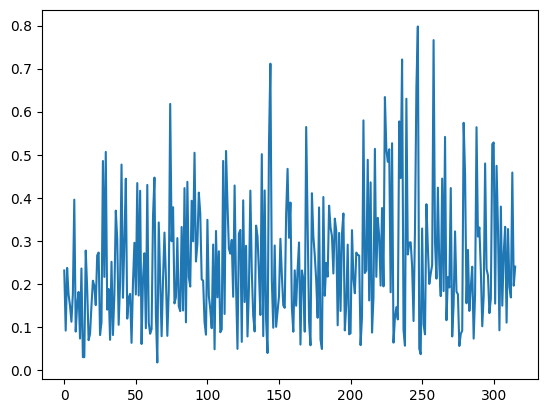

In [57]:
import matplotlib.pyplot as plt

plt.plot(distances);

Hm, cool! It's interesting to see sections where distances are smaller and then areas of larger distances. What stands out to me most is the outliers which are spread out.

There are many ways to chunk up the essay based off these distances, but I'm going to consider any distance above the 95th percentile of distances as a break point. This is the only parameter we'll need to config.

I'm going to build in the final viz, check out the video for an iterative build and an overview.

Let's look at the chunks that came out

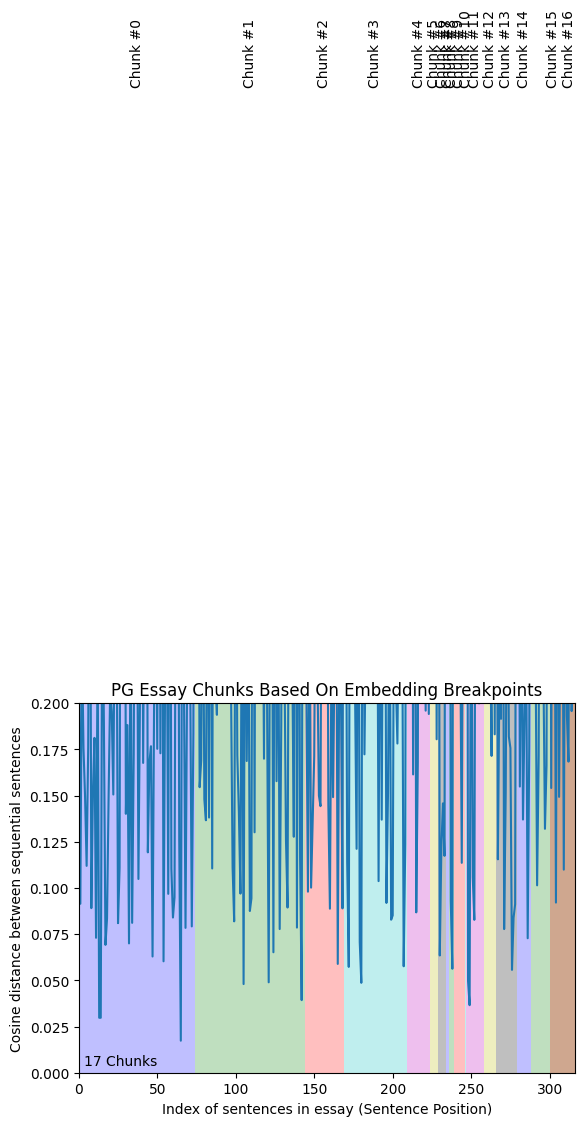

In [58]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.

Because we have our breakpoints [23, 40, 51...] I want to make the first chunk 0-22, since the distance jumped on sentence 23.

In [59]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

Great now let's manually inspect a few to make sure they look ok.

In [60]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
Want to start a startup? Get funded by
Y Combinator. October 2006(This essay is derived from a talk at MIT.)Till recently graduating seniors had two choices: get a job or go
to grad school. I think
...
ater) but can live
as cheaply as an undergrad.Robert Morris and I were 29 and 30 respectively when we started
Viaweb, but fortunately we still lived like 23 year olds. We both had
roughly zero assets.


Chunk #1
I would have loved to have a mortgage,
since that would have meant I had a house. But in retrospect
having nothing turned out to be convenient. I wasn't tied down and
I was used to living cheaply.Even
...
ce co-founders meet is at work. Fewer do than at
school, but there are things you can do to improve the odds. The
most important, obviously, is to work somewhere that has a lot of
smart, young people.




I want to re-emphasize that this is an exploration of a method that is far from usable yet. This method should be tested with RAG eval to ensure that it works for your use case.

I didn't worry about chunk size or overlap with this method, but you could recursively split large chunks if you needed to.

How should it be improved? Let me [know](https://twitter.com/GregKamradt)! See me tease this [here](https://twitter.com/GregKamradt/status/1737921395974430953).

## Level 5: Agentic Chunking <a id="AgenticChunking"></a>
Taking level 4 even further - can we instruct an LLM to do this task like a human would?

How does a human even go about chunking in the first place?

Well...let me think, how would I go about chunking a document into its discrete parts such that the results were semantically similar?

1. I would get myself a scratch piece of paper or notepad
2. I'd start at the top of the essay and assume the first part will be a chunk (since we don't have any yet)
3. Then I would keep going down the essay and evaluate if a new sentence or piece of the essay should be a part of the first chunk, if not, then create a new one
4. Then keep doing that all the way down the essay until we got to the end.

Woah! Wait a minute - this is pseudo code for something we can try out. See me tease this [here](https://twitter.com/GregKamradt/status/1738276097471754735).

I debated whether or not to hold myself to the strict standard of using the *raw text* from a document, or use a derived form. The former felt like I was being too harsh, so I decided to explore using [propositions](https://twitter.com/LangChainAI/status/1735708004618764470). This is a cool concept ([research paper](https://arxiv.org/pdf/2312.06648.pdf)) that extracts stand alone statements from a raw piece of text.

Example: `Greg went to the park. He likes walking` > `['Greg went to the park.', 'Greg likes walking']`

Let's do it:

In [61]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

Pulling out propositions is done via a well-crafted prompt. I'm going to pull it from [LangHub](https://smith.langchain.com/hub?organizationId=50995362-9ea0-4378-ad97-b4edae2f9f22), LangChain's home for prompts.

You can view the proposition prompt [here](https://smith.langchain.com/hub/wfh/proposal-indexing?organizationId=50995362-9ea0-4378-ad97-b4edae2f9f22).

I'll use gpt-4 as the LLM because we aren't messing around. I care more about performance than I do speed or cost.

In [62]:
obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI(model='gpt-4-1106-preview', openai_api_key = os.getenv("OPENAI_API_KEY", 'YouKey'))

Then I'll make a runnable w/ langchain, this'll be a short way to combine the prompt and llm

In [63]:
# use it in a runnable
runnable = obj | llm

The output from a runnable is a json-esque structure in a string. We need to pull the sentences out. I found that LangChain's example extraction was giving me a hard time so I'm doing it manually with a pydantic data class. There is definitely room to improve this.

Create your class then put it in an extraction chain.

In [64]:
# Pydantic data class
class Sentences(BaseModel):
    sentences: List[str]
    
# Extraction
extraction_chain = create_extraction_chain_pydantic(pydantic_schema=Sentences, llm=llm)

Then wrap it together in a function that'll return a list of propositions to us

In [65]:
def get_propositions(text):
    runnable_output = runnable.invoke({
    	"input": text
    }).content
    
    propositions = extraction_chain.run(runnable_output)[0].sentences
    return propositions

Go get your text of choice.

In [68]:
# This file was not found at the repo ...
# https://github.com/gkamradt/langchain-tutorials/tree/main/data

# I manually created this file from copying the text from here ...
# https://paulgraham.com/superlinear.html
# ... into this text file.
with open('PaulGrahamEssayMedium/superlinear.txt') as file:
    essay = file.read()

Then you need to decide what you send to your proposal maker. The prompt has an example that is about 1K characters long. So I would experiment with what works for you. This isn't another chunking decision, just pick something reasonable and try it out.

I'm using paragraphs

In [69]:
paragraphs = essay.split("\n\n")

Let's see how many we have

In [70]:
len(paragraphs)

89

That's too many for a demo, I'll do just the first couple to show it off.

In [71]:
essay_propositions = []

for i, para in enumerate(paragraphs[:5]):
    propositions = get_propositions(para)
    
    essay_propositions.extend(propositions)
    print (f"Done with {i}")

# 1m 6.9s

/home/rob/miniforge3/envs/mls2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Done with 0
Done with 1
Done with 2
Done with 3
Done with 4


Let's take a look at what the propositions look like

In [72]:
print (f"You have {len(essay_propositions)} propositions")
essay_propositions[:10]

You have 23 propositions


['Returns are superlinear.',
 'The month is October.',
 'The year is 2023.',
 'When I was a child, I did not understand one important thing about the world.',
 'The important thing I did not understand is the degree to which the returns for performance are superlinear.',
 'Teachers and coaches implicitly told us the returns were linear.',
 'Teachers and coaches meant well.',
 "The statement 'You get out what you put in' was heard a thousand times.",
 "The statement 'You get out what you put in' is rarely true.",
 "If your product is only half as good as your competitor's product, you do not get half as many customers."]

So you'll see that they look like regular sentences, but they are actually statements that are able to stand on their own. For example, one of the sentences in the raw text is "They meant well, but this is rarely true." if you were to chunk that on it's own, the LLM would have no idea who you're talking about. Who meant well? What is rarely true? But those have been covered by the propositions.

Now onto the cool part, we need a system that can reason about each proposition and determine whether or not it should be a part of an existing chunk or if a new chunk should be made.

The pseudo code for how this works is above - I also review this code in the video so make sure to go watch that if you want to see me chat about it live.

The script is also in this repo if you've cloned it.

In [74]:
# mini script I made
from agentic_chunker import AgenticChunker

In [75]:
ac = AgenticChunker()

Then let's pass in our propositions to it. There are a lot in the full list so I'm only going to do a subset.

This method is slow and expensive, but let's see how the results are.

You can turn off the print statements via setting `ac = AgenticChunker(print_logging=False)` when you create your chunker.

In [76]:
ac.add_propositions(essay_propositions)

# 2m 56.3s


Adding: 'Returns are superlinear.'
No chunks, creating a new one
Created new chunk (d5c54): Investment Returns

Adding: 'The month is October.'
No chunks found
Created new chunk (906b7): Date & Times

Adding: 'The year is 2023.'
Chunk Found (906b7), adding to: Date & Times

Adding: 'When I was a child, I did not understand one important thing about the world.'
No chunks found
Created new chunk (21608): Childhood Misconceptions

Adding: 'The important thing I did not understand is the degree to which the returns for performance are superlinear.'
Chunk Found (d5c54), adding to: Investment Returns

Adding: 'Teachers and coaches implicitly told us the returns were linear.'
Chunk Found (d5c54), adding to: Superlinear Returns in Performance & Economics

Adding: 'Teachers and coaches meant well.'
No chunks found
Created new chunk (32365): Education & Mentorship Attitudes

Adding: 'The statement 'You get out what you put in' was heard a thousand times.'
Chunk Found (d5c54), adding to: Superli

Cool, looks like a few chunks were made. Let's check them out

In [77]:
ac.pretty_print_chunks()


You have 6 chunks

Chunk #0
Chunk ID: d5c54
Summary: This chunk discusses the concept of superlinear returns, challenging the notion of linear rewards and exploring its prevalence in business, fame, power, knowledge, and societal impact.
Propositions:
    -Returns are superlinear.
    -The important thing I did not understand is the degree to which the returns for performance are superlinear.
    -Teachers and coaches implicitly told us the returns were linear.
    -The statement 'You get out what you put in' was heard a thousand times.
    -The statement 'You get out what you put in' is rarely true.
    -If your product is only half as good as your competitor's product, you do not get half as many customers.
    -The returns for performance are superlinear in business.
    -Some people think the superlinear returns for performance are a flaw of capitalism.
    -Some people think that changing the rules would stop the superlinear returns for performance from being true.
    -Superline

Awesome, then if we wanted to get the chunks properly, then we get extract a list of strings with them. The chunks propositions will be joined in the same string

In [78]:
chunks = ac.get_chunks(get_type='list_of_strings')

In [79]:
chunks

["Returns are superlinear. The important thing I did not understand is the degree to which the returns for performance are superlinear. Teachers and coaches implicitly told us the returns were linear. The statement 'You get out what you put in' was heard a thousand times. The statement 'You get out what you put in' is rarely true. If your product is only half as good as your competitor's product, you do not get half as many customers. The returns for performance are superlinear in business. Some people think the superlinear returns for performance are a flaw of capitalism. Some people think that changing the rules would stop the superlinear returns for performance from being true. Superlinear returns for performance are a feature of the world. Superlinear returns for performance are not an artifact of rules that have been invented by humans. The same pattern of superlinear returns is seen in fame. The same pattern of superlinear returns is seen in power. The same pattern of superlinear

Great, now we can go use that in our evaluations for your retrieval.

## Bonus Level: Alternative Representation <a id="BonusLevel"></a>
So far I've shown how to chunk up your raw text (okay, I was a bit liberal with level 5).

But what if your raw text isn't the best way to represent your data for your task?

For example, if you're doing semantic search on chat messages, raw chat messages may lack the context to make a successful embedding. Maybe actually trying to semantic search of a summary of a conversation would do better. Or maybe hypothetical questions that the chat would answer?

This is where the world of chunking/splitting starts to dive into the world of [indexing](https://docs.llamaindex.ai/en/stable/understanding/indexing/indexing.html#what-is-an-index). When you index, you're making a choice about how you want to represent your data in your data base or knowledge base.

This is more of a retrieval topic, but it's worth talking about with chunking.

Let's quickly go through a few popular alternative ways developers like to represent their data. There are unlimited methods to try. We'll review 4 of them

* **[Multi-Vector Indexing](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector)** - This is when you do semantic search for a vector that is derived from something other than your raw text
    * **Summaries** - A summary of your chunk
    * **Hypothetical questions** - Good for chat messages used as knowledge base
    * **Child Documents** - Parent Document Retriever
* **Graph Based Chunking** - Transposing your raw text into a graph structure

### Summaries
Instead of embedding your raw text, embed a summary of your raw text which will have more dense information

In [80]:
import uuid

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

Let's use our Super Linear essay again. I'll split it into large chunks

In [81]:
with open('PaulGrahamEssayMedium/superlinear.txt') as file:
    essay = file.read()

splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=0)

docs = splitter.create_documents([essay])

print (f"You have {len(docs)} docs")

You have 7 docs


Spin up a chain that will quickly summarize for you

In [82]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(max_retries=0)
    | StrOutputParser()
)

Then let's get the summaries

In [83]:
summaries = chain.batch(docs, {"max_concurrency": 5})

# 5.9s

Let's look at a sample

In [84]:
summaries[0]

'The document discusses the concept of superlinear returns, where the returns for performance are greater than the effort put in. It explains that this phenomenon is seen in various areas such as business, fame, power, military victories, and knowledge. The document also emphasizes the importance of understanding superlinear returns, especially for ambitious individuals. It further explores the causes of superlinear returns, such as exponential growth and thresholds, using examples like bacterial cultures and startups. The document concludes by discussing the lack of customs or understanding around exponential growth in human history and how it has affected society.'

Then we are going to create a vectorstore (holds vectors + summaries) and a docstore (holds raw docs)

In [85]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryByteStore()

id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

Then you want to create documents out of your summary list, add the doc_id to it's metadata. This will tie it back to the original document so you know which summary goes with which original doc.

In [86]:
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

Then add them both to your vectorestore and docstore. When you add the docs to the vectorstore it will get the embeddings for them too.

In [87]:
# Adds the summaries
retriever.vectorstore.add_documents(summary_docs)

# Adds the raw documents
retriever.docstore.mset(list(zip(doc_ids, docs)))

Then if you want you can add the original docs to the vectorstore as well. Just make sure to add the doc id to it as well so you can tie it all together

In [88]:
# for i, doc in enumerate(docs):
#     doc.metadata[id_key] = doc_ids[i]
# retriever.vectorstore.add_documents(docs)

Great, now that we've done all that work, let's try a search. If you run the code below, you'll search on the summary embeddings, but you'll get the raw documents returned.

In [ ]:
# retriever.get_relevant_documents(query="the concept of superlinear returns, which refers to the idea that the returns for performance are not linear")

### Hypothetical Questions
You can generate hypothetical questions about your raw documents. Check out [LangChain's](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#hypothetical-queries) implementation of it for more information.

This is espeically helpful when you have sparse unstructured data, like chat messages.

Say you were to build a bot that uses slack conversations as a knowledge base. Trying to do semantic search on raw chat messages might not have the greatest results. However, if you were to generate hypothetical questions that the slack messages would answer, then when you get a new question in, you'll likely have a better chance matching.

The code for this will be the same as the summary code, but instead of asking the LLM to make a summary, you'll ask it for hypothetical questions.

### Parent Document Retriever (PDR)
Much like the previous two, Parent Document Retriever builds on the concept of doing semantic search on a varied representation of your data.

The hypothesis with the PDR is that smaller chunks have a higher likely hood of being matched semantically with a potential query. However, those smaller chunks may not have all the context they need, so instead of passing the smaller chunks to your LLM, get the parent chunk of the smaller chunk. This means you get a larger chunk which the smaller chunk is placed in.

Check out LangChain's implementation's implementation of it [here](https://python.langchain.com/docs/modules/data_connection/retrievers/parent_document_retriever).

I have a full tutorial on it at [FullStackRetrieval.com](https://fullstackretrieval.com/) if you want to go deeper on that.

I want to quickly go over a similar method in [Llama Index](https://www.llamaindex.ai/) with their `HierarchicalNodeParser` which will split a document at various chunk sizes (there will be a bunch of overlaps but that is the purpose). When combined with their `AutoMergingRetriever` you can do complicated retrieval easily. Their walkthrough [here](https://docs.llamaindex.ai/en/stable/examples/retrievers/auto_merging_retriever.html).

In [89]:
from llama_index.node_parser import HierarchicalNodeParser

node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128],
    chunk_overlap=0
)

In [90]:
documents = SimpleDirectoryReader(
    input_files=["PaulGrahamEssayMedium/mit.txt"]
).load_data()

Then let's do our splitting. There will be a bunch of chunks since we included `128` as a chunk size above

In [91]:
nodes = node_parser.get_nodes_from_documents(documents)

In [92]:
print (f"You have {len(nodes)} nodes")

You have 118 nodes


Then let's look at the relationships that are available to one of the small nodes at the end

In [93]:
nodes[-2].relationships

{<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='cf6a1ce7-6eec-4e93-a42c-57592e297128', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': 'PaulGrahamEssayMedium/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36044, 'creation_date': '2024-02-15', 'last_modified_date': '2024-02-15', 'last_accessed_date': '2024-03-28'}, hash='6e8601eab89c5f0206b12e13db36146e4e62aa63ba4c3f8a7c8b87f878c54647'),
 <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='ca974ed7-fec1-41ff-b990-14f55cd38813', node_type=<ObjectType.TEXT: '1'>, metadata={'file_path': 'PaulGrahamEssayMedium/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 36044, 'creation_date': '2024-02-15', 'last_modified_date': '2024-02-15', 'last_accessed_date': '2024-03-28'}, hash='a58689f5302073a4533aa43ad0deffa83a28b52a207772dd595f63853ca177af'),
 <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='eabb73b3-4dca-4caf-aad9-07ad60a39610', node_type=<ObjectType.TEXT: '1'

You can see there are source, previous, next, and parent. For [more information on these](https://docs.llamaindex.ai/en/stable/api/llama_index.schema.NodeRelationship.html).

### Graph Structure
If your data is rich with entities, relationships, and connections, then a graph structure may be best for you.

Few options:
* [Diffbot](https://www.diffbot.com/)
* [InstaGraph](https://github.com/yoheinakajima/instagraph) - By [Yohei](https://twitter.com/yoheinakajima)

I'll run through the LangChain supported version of Diffbot due to brevity. You'll need an API key from DB

In [ ]:
# !pip3 install langchain langchain-experimental openai neo4j wikipedia

from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer

diffbot_nlp = DiffbotGraphTransformer(diffbot_api_key=os.getenv("DIFFBOT_API_KEY", 'YourKey'))

In [ ]:
text = """
Greg is friends with Bobby. San Francisco is a great city, but New York is amazing.
Greg lives in New York. 
"""
docs = [Document(page_content=text)]

In [ ]:
graph_documents = diffbot_nlp.convert_to_graph_documents(docs)

In [ ]:
graph_documents

## Wrap up

Congratulations on making it to the end of this video. The aim was to educate you on the chunking theory, give a nod to retrieval, and encourage you to try out these methods on your data.

I always like hearing what you think about the code, video or how you use this in your role. Let me know on [twitter](https://twitter.com/GregKamradt) or email (contact@dataindependent.com)